# Statistical models in R
This notebook is covering:
1. VECM

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [3]:
# rpy2 is a Python package that allows you to run R code from Python
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the rpy2 extension to use R in Jupyter
%load_ext rpy2.ipython

The magic function `%%R` is used for running R code in Jupyter

In [53]:
%%R
source("tvecm.r")
hub1_name <- "the"
hub2_name <- "nbp"
validation_size <- 250
test_size <- 250
window_size <- 5
nthresh <- 2

110 (0.5%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first search -17.53039 
Best cointegrating value 1.216685 
Second best (conditionnal on the first one) -17.53039 29.97774 	 SSR 82937.56 
Second step best thresholds -17.53881 29.97774 			 SSR 82804.92 
110 (0.5%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first search -17.53039 
Best cointegrating value 1.220197 
There were  2  thresholds values which minimize the SSR in the conditional step, the first one was taken
Second best (conditionnal on the first one) -17.53039 31.06071 	 SSR 81182.63 
There were  4  thresholds values which minimize the SSR in the iterative step, the first one was taken
Second step best thresholds -17.8085 31.06071 			 SSR 81077.12 
110 (0.5%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first 

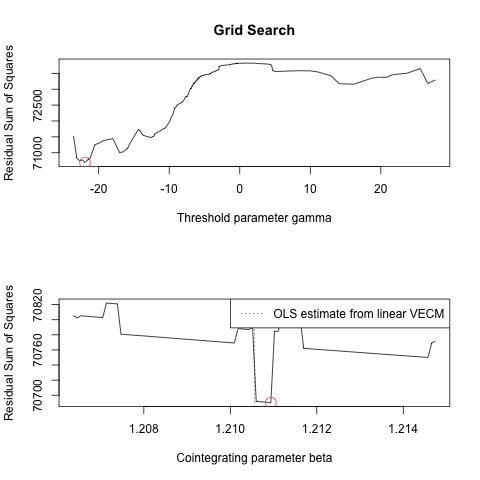

In [54]:
%%R
vecm_output <- tvecm_system(hub1_name, hub2_name, validation_size=validation_size, test_size=test_size, window_size=window_size, nthresh=nthresh, verbose=TRUE, save=TRUE)

110 (0.5%) points of the grid lead to regimes with percentage of observations < trim and were not computed
#############
###Model TVECM
#############
Full sample size: 1290 	End sample size: 1284
Number of variables: 2 	Number of estimated parameters 48
AIC 7187.181 	BIC 7439.91 	SSR 78255.37 


Cointegrating vector: (1, - 1.21676 )
$Bdown
              ECT                Const               hub1 t -1       
Equation hub1 0.7177(4.6e-12)*** 17.6936(1.5e-11)*** -0.1086(0.6612) 
Equation hub2 0.8221(2.8e-13)*** 20.2151(1.1e-12)*** -0.1933(0.4714) 
              hub2 t -1       hub1 t -2        hub2 t -2      
Equation hub1 0.4402(0.0623). -0.2292(0.3094)  0.1931(0.3711) 
Equation hub2 0.5478(0.0322)* -0.0531(0.8280)  0.0236(0.9195) 
              hub1 t -3          hub2 t -3         hub1 t -4      
Equation hub1 -0.7456(0.0013)**  0.7026(0.0015)**  0.3772(0.0995).
Equation hub2 -0.8726(0.0005)*** 0.8330(0.0005)*** 0.4663(0.0602).
              hub2 t -4        hub1 t -5          hub2 t -

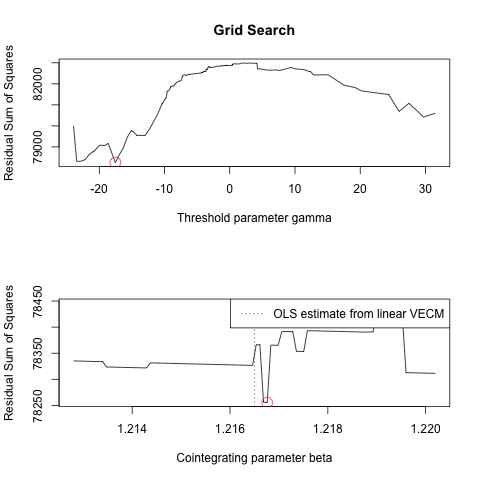

In [55]:
%%R
training_model <- tvecm_training_model(hub1_name, hub2_name, test_size, window_size, lag=5)
summary(training_model)

In [56]:
%%R
hub1_predictions <- vecm_output$predictions$hub1
hub1_actuals <- vecm_output$actuals$hub1
hub2_predictions <- vecm_output$predictions$hub2
hub2_actuals <- vecm_output$actuals$hub2


In [57]:
%%R
hub1_forecast_comparison <- data.frame(
  Actual = hub1_actuals,
  Forecasted = hub1_predictions
)

In [58]:
%R -o hub1_forecast_comparison
%R -o hub1_name

hub1_forecast_comparison = hub1_forecast_comparison

actual_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub1_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()


In [59]:
%%R
hub2_forecast_comparison <- data.frame(
  Actual = hub2_actuals,
  Forecasted = hub2_predictions
)

In [60]:
%R -o hub2_forecast_comparison
%R -o hub2_name

hub2_forecast_comparison = hub2_forecast_comparison

actual_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub2_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()
